# Nginx log analysis with Pandas

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

%matplotlib inline 

# Data import - here be regex

The log format I use for nginx:

    '$remote_addr - $remote_user [$time_local] '
    '"$request" $status $body_bytes_sent '
    '"$http_referer" "$http_user_agent" '
    '$request_time $upstream_response_time $pipe';
The following regex will match 

In [20]:
pattern = re.compile(r"""(?P<remote_addr>.+?) \s-\s
            (?P<remote_user>.+?) \s
            \[(?P<time_local>.+?)\] \s 
            "(?P<method>.+?) \s (?P<uri>.+?) \s (?P<protocol>.+?)" \s
            (?P<status>.+?) \s
            (?P<body_bytes_sent>.+?) \s
            "(?P<http_referer>.+?)"? \s # Optional final " as I initially missed this when setting the format
            "(?P<http_user_agent>.*?)" \s
            (?P<request_time>.+?) \s
            (?P<upstream_response_time>.+?) \s
            (?P<pipe>.+?)""", re.VERBOSE)

In [21]:
test = """195.211.155.181 - - [18/Jan/2015:22:43:05 +0000] "GET /blog/email-templates-using-zend-framework/ HTTP/1.1" """ + \
        """200 7408 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; Mozilla/4.0 (compatible; MSIE 6.0; """ + \
        """Windows NT 5.1; SV1) )" 0.039 0.039 ."""

m = re.match(pattern, test)
m.groupdict()

{'body_bytes_sent': '7408',
 'http_referer': '-',
 'http_user_agent': 'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1) )',
 'method': 'GET',
 'pipe': '.',
 'protocol': 'HTTP/1.1',
 'remote_addr': '195.211.155.181',
 'remote_user': '-',
 'request_time': '0.039',
 'status': '200',
 'time_local': '18/Jan/2015:22:43:05 +0000',
 'upstream_response_time': '0.039',
 'uri': '/blog/email-templates-using-zend-framework/'}

With our working regex pattern we can parse every line in the log file and store the data in a list of dicts

In [22]:
log_file = '/home/jonathan/dev/access.log'

with open(log_file) as f:
    log_list = []
    for i in f.readlines():
        m = re.match(pattern, i)
        log_list.append(m.groupdict())

Converting the data to a pandas DataFrame only requires passing the list to pd.DataFrame

In [23]:
log = pd.DataFrame(log_list)

print(log.head(1))

  body_bytes_sent http_referer  \
0            2355            -   

                                     http_user_agent method pipe  protocol  \
0  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....    GET    .  HTTP/1.1   

     remote_addr remote_user request_time status                  time_local  \
0  173.79.236.46           -        0.005    200  29/Jul/2014:02:32:01 +0100   

  upstream_response_time uri  
0                  0.005   /  


# Inspecting the dataframe

In [24]:
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335085 entries, 0 to 335084
Data columns (total 13 columns):
body_bytes_sent           335085 non-null object
http_referer              335085 non-null object
http_user_agent           335085 non-null object
method                    335085 non-null object
pipe                      335085 non-null object
protocol                  335085 non-null object
remote_addr               335085 non-null object
remote_user               335085 non-null object
request_time              335085 non-null object
status                    335085 non-null object
time_local                335085 non-null object
upstream_response_time    335085 non-null object
uri                       335085 non-null object
dtypes: object(13)
memory usage: 35.8+ MB


Currently, all columns are object type. The data will be easier to work with if the types are converted where appropriate

+ time_local -> datetime
+ upstream_response_time -> float
+ request_time -> float
+ body_bytes_sent -> integer

status is a numerical code so could be converted to an integer but as this is a categorical variable we probably don't need to convert it

In [25]:
log['time_local'] = pd.to_datetime(log['time_local'].apply(lambda x : x.split(' ')[0]), format='%d/%b/%Y:%H:%M:%S')

log.loc[log['upstream_response_time'] == '-', 'upstream_response_time'] = np.nan
log[['upstream_response_time', 'request_time']] = log[['upstream_response_time', 'request_time']].astype(np.float64)
log['body_bytes_sent'] = log['body_bytes_sent'].astype(np.int64)

log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335085 entries, 0 to 335084
Data columns (total 13 columns):
body_bytes_sent           335085 non-null int64
http_referer              335085 non-null object
http_user_agent           335085 non-null object
method                    335085 non-null object
pipe                      335085 non-null object
protocol                  335085 non-null object
remote_addr               335085 non-null object
remote_user               335085 non-null object
request_time              335085 non-null float64
status                    335085 non-null object
time_local                335085 non-null datetime64[ns]
upstream_response_time    294004 non-null float64
uri                       335085 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 35.8+ MB


The index is currently the default, an incrementing number (in this case 0 to 335084).

Setting the index to the time of the request will simplify analysis later.

In [26]:
log.index = log.pop('time_local')
log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335085 entries, 2014-07-29 02:32:01 to 2015-01-18 22:03:33
Data columns (total 12 columns):
body_bytes_sent           335085 non-null int64
http_referer              335085 non-null object
http_user_agent           335085 non-null object
method                    335085 non-null object
pipe                      335085 non-null object
protocol                  335085 non-null object
remote_addr               335085 non-null object
remote_user               335085 non-null object
request_time              335085 non-null float64
status                    335085 non-null object
upstream_response_time    294004 non-null float64
uri                       335085 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 33.2+ MB


Basic summary information is available with the describe method

In [27]:
log.describe()

,body_bytes_sent,request_time,upstream_response_time
count,335085.000000,335085.000000,294004.000000
mean,50860.877577,0.505884,0.071010
std,95728.088827,2.068734,0.077905
min,0.000000,0.000000,0.000000
25%,5786.000000,0.038000,0.037000
50%,13548.000000,0.152000,0.043000
75%,24858.000000,0.460000,0.086000
max,3943976.000000,209.385000,3.760000


Some of the requests take a long time. Let's take a closer look

## Response time analysis

In [28]:
mask = log['upstream_response_time'] > 1.0
log[mask].shape

(24, 12)

In [29]:
selected_columns = ['request_time', 'status', 'upstream_response_time', 'uri']
log.loc[mask, selected_columns].sort('upstream_response_time', ascending=False)

,request_time,status,upstream_response_time,uri
time_local,,,,
2014-08-22 10:37:23,3.760,200,3.760,/admin/blog/comment/?spam__isnull=True
2014-08-22 22:26:33,2.703,200,2.703,/admin/blog/comment/?
2014-08-26 01:00:09,2.265,200,2.004,/blog/atom/
2014-08-05 13:40:57,2.701,200,1.789,/blog/ai-cookbook-competition/
2014-09-25 15:30:48,1.861,200,1.450,/blog/bcne3-search-phpbb-with-sphinx/
2014-08-22 00:43:35,1.433,200,1.433,/admin/blog/comment/
2014-08-22 15:21:26,1.896,200,1.419,/blog/atom/
2014-08-26 19:20:03,2.207,200,1.415,/blog/tag/python/atom/
2014-09-02 00:13:06,1.326,200,1.326,/blog/ai-cookbook-competition/


The slowest requests are on the back end but a couple of blog posts and the atom feed also appear to be slow. Are they always slow or were these requests anomalous?

In [30]:
mask = log['uri'] == '/blog/atom/'
log[mask].describe()

,body_bytes_sent,request_time,upstream_response_time
count,20331.000000,20331.000000,20329.000000
mean,281056.742610,0.843777,0.249729
std,21001.686369,1.342209,0.053137
min,0.000000,0.000000,0.216000
25%,282935.000000,0.481000,0.227000
50%,282935.000000,0.550000,0.234000
75%,282935.000000,0.692000,0.253000
max,283197.000000,66.848000,2.004000


In [31]:
np.percentile(log.loc[log['uri'] == '/blog/atom/', 'upstream_response_time'], 95)

0.31900000000000001

## Traffic analysis

### Daily requests

In [32]:
log_freq = log['body_bytes_sent'].resample('D', how='count')

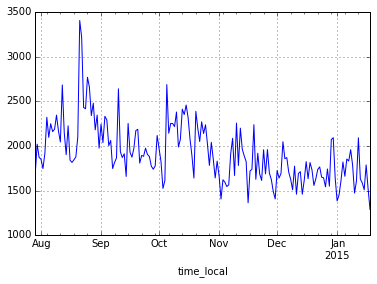

In [33]:
log_freq.plot()

### Top URIs

In [34]:
top_uri = log.groupby('uri').size()
top_uri.sort()
top_uri.tail(10)

uri
/blog/disk-space-database-table-mysql-postgresql/      5902
/static/js/bootstrap.min.js                            6137
/static/css/bootstrap.css                              6424
/blog/atom/1                                          10395
/blog/atom/1/                                         11856
/blog/ai-cookbook-competition/                        17941
/blog/tag/python/atom/                                19729
/blog/atom/                                           20331
/                                                     20336
/blog/bcne3-search-phpbb-with-sphinx/                110334
dtype: int64

In [35]:
uri_mask = log['uri'] == '/blog/bcne3-search-phpbb-with-sphinx/'
selected_columns = ['remote_addr', 'method', 'http_user_agent', 'http_referer']
log.loc[mask, selected_columns].describe()

,remote_addr,method,http_user_agent,http_referer
count,20331,20331,20331,20331
unique,401,2,114,11
top,72.196.9.247,GET,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,-
freq,1596,20243,8339,20301


In [36]:
uri_mask = log['uri'] == '/blog/bcne3-search-phpbb-with-sphinx/'
method_mask = log['method'] == 'POST'
mask = uri_mask & method_mask

selected_columns = ['remote_addr', 'method', 'http_user_agent', 'http_referer']

log.loc[mask, selected_columns].describe()

,remote_addr,method,http_user_agent,http_referer
count,45414,45414,45414,45414
unique,3251,1,271,2
top,66.117.8.34,POST,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,http://jonathanstreet.com/blog/bcne3-search-ph...
freq,3351,45414,5413,45411


## Resources & Further Inspiration

+ [Pandas](http://pandas.pydata.org/)
+ [Matplotlib](http://matplotlib.org/)
+ [Numpy](http://www.numpy.org/)


+ [Another notebook exploring similar themes](http://nbviewer.ipython.org/github/koldunovn/nk_public_notebooks/blob/master/Apache_log.ipynb)


+ [Importing Google Analytics data into pandas](http://pandas.pydata.org/pandas-docs/stable/remote_data.html#remote-data-ga)